In [29]:
!pip install openpyxl

In [30]:
import pandas as pd
import functools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Loading the Files
try:
    df_events = pd.read_excel("analytics_engineer_harvey_mock_data.xlsx", sheet_name='events')
    df_firms = pd.read_excel("analytics_engineer_harvey_mock_data.xlsx", sheet_name='firms')
    df_users = pd.read_excel("analytics_engineer_harvey_mock_data.xlsx", sheet_name='users')
except Exception as e:
    print(f"Error loading files: {e}")

print("--- Events Info ---")
df_events.info()

print("\n--- Firms Info ---")
df_firms.info()

print("\n--- Users Info ---")
df_users.info()


--- Events Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18832 entries, 0 to 18831
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CREATED         18832 non-null  datetime64[ns]
 1   FIRM_ID         18832 non-null  int64         
 2   USER_ID         18832 non-null  object        
 3   EVENT_TYPE      18832 non-null  object        
 4   NUM_DOCS        18832 non-null  int64         
 5   FEEDBACK_SCORE  18832 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 882.9+ KB

--- Firms Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                32 non-null     int64         
 1   CREATED           32 non-null     datetime64[ns]
 2   FIRM_SIZE         32 non-null     int64   

In [32]:
# converting all the field names to lowercase for sanity and consistency
for df in [df_events,df_firms, df_users]:
    df.columns = df.columns.str.lower()

In [33]:
print("\n--- Events Data View ---")
print(df_events.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Firms Data View---")
print(df_firms.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Users Data View---")
print(df_users.head().to_markdown(index=False, numalign="left", stralign="left"))


--- Events Data View ---
| created                    | firm_id   | user_id                          | event_type   | num_docs   | feedback_score   |
|:---------------------------|:----------|:---------------------------------|:-------------|:-----------|:-----------------|
| 2024-05-28 09:37:37.410000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | WORKFLOW     | 1          | 4                |
| 2024-05-15 11:46:09.294000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | WORKFLOW     | 1          | 5                |
| 2024-05-13 18:36:51.225000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | VAULT        | 23         | 4                |
| 2024-05-13 18:27:19.964000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | ASSISTANT    | 1          | 4                |
| 2024-05-13 17:53:24.145000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | ASSISTANT    | 1          | 4                |

--- Firms Data View---
| id     | created             | firm_size   | arr_in_thousands   |
|:-----

# Data Modeling

## Model 1: Events Model

In [34]:
# Number of Unique event_type
print("Unique event Names: {0}".format(df_events.event_type.unique()))
# Number of Unique users
print("Unique Users to Match with the shared Users Table: {0}".format(df_events.user_id.nunique()))
# maximum and miminum date of events to get an estimate on the timeline
print("Minimum Event Date: {0} , Maximum Event Date: {1}".format(df_events.created.min(),df_events.created.max()))

Unique event Names: ['WORKFLOW' 'VAULT' 'ASSISTANT']
Unique Users to Match with the shared Users Table: 2948
Minimum Event Date: 2024-04-02 00:25:58.805000 , Maximum Event Date: 2024-06-26 03:31:54.049000


## Events Model Breakdown
 - **Goal:** One row per user per month for usage metrics over time per event_type
 - **Process Involved** 
      1. **Grain**: User Id and month of the event
      2. Fact1: Aggregating the events to calculate:
          - *monthly_queries* ( count of events)
          - *first_active_date* (min of created/event_timestamp)
          - *last_active_date* ( max of created/event_timestamp)
          - *average_feedback_score* (avg of feedback score)
      3. Fact2: Conditional Aggregation of specific event type ( event_type count and average feedback score)

In [35]:
# Pre-processing and Renaming in df_events
df_events['created'] = pd.to_datetime(df_events['created'])
df_events.rename(columns={'created': 'event_timestamp'}, inplace=True)
print(df_events.head().to_markdown(index=False, numalign="left", stralign="left"))

| event_timestamp            | firm_id   | user_id                          | event_type   | num_docs   | feedback_score   |
|:---------------------------|:----------|:---------------------------------|:-------------|:-----------|:-----------------|
| 2024-05-28 09:37:37.410000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | WORKFLOW     | 1          | 4                |
| 2024-05-15 11:46:09.294000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | WORKFLOW     | 1          | 5                |
| 2024-05-13 18:36:51.225000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | VAULT        | 23         | 4                |
| 2024-05-13 18:27:19.964000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | ASSISTANT    | 1          | 4                |
| 2024-05-13 17:53:24.145000 | 1063      | 001f04ed53bd5bc8aeaf7c099f7308a5 | ASSISTANT    | 1          | 4                |


In [36]:
# User-Month Grain
df_events['activity_month'] = df_events['event_timestamp'].dt.to_period('M').dt.to_timestamp()

# Aggregations for metrics
user_month_agg = df_events.groupby(['user_id', 'activity_month'], as_index=False)\
                .agg(monthly_queries=('event_timestamp', 'count'),\
                    first_active_date=('event_timestamp', 'min'),\
                        last_active_date=('event_timestamp', 'max'),\
                            avg_feedback_score=('feedback_score', 'mean'),\
                                distinct_event_types=('event_type', 'nunique'))


# 

In [37]:
user_month_agg

,user_id,activity_month,monthly_queries,first_active_date,last_active_date,avg_feedback_score,distinct_event_types
0,001f04ed53bd5bc8aeaf7c099f7308a5,2024-05-01,12,2024-05-09 10:17:05.011,2024-05-28 09:37:37.410,4.25,3
1,004c8681bd00ff1407736ab1549c24f6,2024-04-01,4,2024-04-03 08:38:56.445,2024-04-09 09:17:25.404,4.50,2
2,004c8681bd00ff1407736ab1549c24f6,2024-05-01,2,2024-05-03 08:46:01.161,2024-05-22 13:51:07.002,3.50,2
3,004d2cd03ef8d602f1d6394c6b70b539,2024-05-01,1,2024-05-28 07:23:15.283,2024-05-28 07:23:15.283,5.00,1
4,004d2cd03ef8d602f1d6394c6b70b539,2024-06-01,1,2024-06-18 13:02:35.421,2024-06-18 13:02:35.421,5.00,1
...,...,...,...,...,...,...,...
4704,ff9af59ee4e334a5cbf9cbc61b2ab7ad,2024-05-01,1,2024-05-30 10:02:52.487,2024-05-30 10:02:52.487,3.00,1
4705,ff9af59ee4e334a5cbf9cbc61b2ab7ad,2024-06-01,5,2024-06-10 09:43:17.732,2024-06-11 14:05:47.877,3.60,3
4706,ffa4451abb959230d9d54570c3ec03dc,2024-05-01,1,2024-05-07 11:22:24.543,2024-05-07 11:22:24.543,5.00,1
4707,ffe45e153259633693db7eaac4f4be74,2024-05-01,7,2024-05-26 11:10:39.901,2024-05-31 18:53:53.092,4.00,3


In [38]:
# Event Counts at grain user, month level
event_type_counts = df_events.pivot_table(
    index=['user_id', 'activity_month'],
    columns='event_type',
    values='event_timestamp',
    aggfunc='count',
    fill_value=0
    ).reset_index().rename(columns=lambda x: f'{x.lower()}_queries' if x not in ['user_id', 'activity_month'] else x)

# Event avg feedback score at grain user, month level
event_type_avg_score = df_events.pivot_table(
    index=['user_id', 'activity_month'],
    columns='event_type',
    values='feedback_score',
    aggfunc='mean',
    fill_value=0
    ).reset_index().rename(columns=lambda x: f'{x.lower()}_feedback_score' if x not in ['user_id', 'activity_month'] else x)

# merge with the actual activity table
user_facts = [user_month_agg,event_type_counts,event_type_avg_score]
user_engagement = ft.reduce(lambda left, right: pd.merge(left, right, how='left', on=['user_id','activity_month']), user_facts)
user_engagement = user_engagement.sort_values(by=['user_id', 'activity_month']).reset_index(drop=True)

In [39]:
print("\n---Data Model 1: Events Model View---")
print(user_engagement.head().to_markdown(index=False, numalign="left", stralign="left"))


---Data Model 1: Events Model View---
| user_id                          | activity_month      | monthly_queries   | first_active_date          | last_active_date           | avg_feedback_score   | distinct_event_types   | assistant_queries   | vault_queries   | workflow_queries   | assistant_feedback_score   | vault_feedback_score   | workflow_feedback_score   |
|:---------------------------------|:--------------------|:------------------|:---------------------------|:---------------------------|:---------------------|:-----------------------|:--------------------|:----------------|:-------------------|:---------------------------|:-----------------------|:--------------------------|
| 001f04ed53bd5bc8aeaf7c099f7308a5 | 2024-05-01 00:00:00 | 12                | 2024-05-09 10:17:05.011000 | 2024-05-28 09:37:37.410000 | 4.25                 | 3                      | 6                   | 4               | 2                  | 4                          | 4.5                    | 4.5  

## Model 2: Firm Usage Model

## Events Model Breakdown
 - **Goal:** One row per firm level
 - **Process Involved** 
      1. **Grain**: Firm level
      2. Aggregating the events to calculate:
          - *total_queries* ( count of events)
          - *active_users* distinct user_id active
          - *last_active_date* ( max of created/event_timestamp)
          - *average_firm_feedback_score* (avg of feedback score)
          - *provisioned_users* (count of provisioned users or users belonging to a firm)
          - *active_to_provisioned_ratio* (derivative: active_users/provisioned_users) 

In [40]:
df_firms.rename(columns={'id': 'firm_id', 'created': 'firm_join_date', 'arr_in_thousands': 'arr_k'}, inplace=True)
df_firms['firm_join_date'] = pd.to_datetime(df_firms['firm_join_date'])

"""
total_queries: firm usage metrics in terms of activity timestamp from events table
active users in each firm: Active users (ever active in the shared events schema)
avg feedback score for each firm: Avg score obtained for each firm_id
"""
firm_usage_metrics = df_events.groupby('firm_id',as_index=False)\
                    .agg(total_queries=('event_timestamp', 'count'),\
                        active_users=('user_id', 'nunique'),\
                            avg_firm_feedback_score=('feedback_score', 'mean'))

"""  
We don't have a direct mapping betweeen the firms and users in those firms to confirm the provisioned users
Assumption: User-Firm Mapping and Provisioned Users (Assumption: A user belongs to the firm they log most events from)
"""
# group by user_id and firm_id to count events
user_firm_counts = df_events.groupby(['user_id', 'firm_id'],as_index=False).agg(event_count=('user_id','count'))

# Find the firm with the maximum event_count for each user (the primary firm)
primary_firm_per_user = user_firm_counts.loc[user_firm_counts.groupby('user_id')['event_count'].idxmax()]

# Calculate Provisioned Users (Provisioned users for a firm are those whose primary firm is that firm_id)
provisioned_users = primary_firm_per_user.groupby('firm_id',as_index=False)\
                    .agg(provisioned_users=('user_id','count'))

In [41]:
print("\n--- Firm Usage Data Model View ---")
print(firm_usage_metrics.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Provisioned Users Data Model View--")
print(provisioned_users.head().to_markdown(index=False, numalign="left", stralign="left"))



--- Firm Usage Data Model View ---
| firm_id   | total_queries   | active_users   | avg_firm_feedback_score   |
|:----------|:----------------|:---------------|:--------------------------|
| 1022      | 747             | 104            | 4.12048                   |
| 1024      | 607             | 116            | 4.06755                   |
| 1035      | 231             | 39             | 4.04329                   |
| 1037      | 1819            | 116            | 4.10225                   |
| 1040      | 236             | 47             | 3.97881                   |

--- Provisioned Users Data Model View--
| firm_id   | provisioned_users   |
|:----------|:--------------------|
| 1022      | 104                 |
| 1024      | 115                 |
| 1035      | 39                  |
| 1037      | 116                 |
| 1040      | 47                  |


In [42]:
firm_usage_df = [df_firms,firm_usage_metrics,provisioned_users]
# Merge the firm_usage_metrics with provisioned_users
firm_usage_summary = ft.reduce(lambda left, right: pd.merge(left,right,how='left',on=['firm_id']),firm_usage_df).fillna(0)
# Calculating Provisioned User Ratio to see an estimate on active vs provisioned users
firm_usage_summary['active_to_provisioned_ratio'] = (firm_usage_summary['active_users'] / firm_usage_summary['provisioned_users'].replace(0, pd.NA))
# sorting by firm_id and save the model 
firm_usage_summary = firm_usage_summary.sort_values(by='firm_id').reset_index(drop=True)

In [43]:
print("\n--- Firm Usage Metrics Data Model View---")
print(firm_usage_summary.head().to_markdown(index=False, numalign="left", stralign="left"))


--- Firm Usage Metrics Data Model View---
| firm_id   | firm_join_date      | firm_size   | arr_k   | total_queries   | active_users   | avg_firm_feedback_score   | provisioned_users   | active_to_provisioned_ratio   |
|:----------|:--------------------|:------------|:--------|:----------------|:---------------|:--------------------------|:--------------------|:------------------------------|
| 1022      | 2023-11-30 00:00:00 | 160         | 250     | 747             | 104            | 4.12048                   | 104                 | 1                             |
| 1024      | 2023-08-08 00:00:00 | 130         | 170     | 607             | 116            | 4.06755                   | 115                 | 1.0087                        |
| 1035      | 2024-01-05 00:00:00 | 40          | 35      | 231             | 39             | 4.04329                   | 39                  | 1                             |
| 1037      | 2023-11-22 00:00:00 | 180         | 200     | 1819        

## Model 3: Daily Event Summary

## Events Model Breakdown
 - **Goal:** Dailiy statistics on events
 - **Process Involved** 
      1. **Grain**: Day
      2. Aggregating the events to calculate:
          - *event_date* calendar date of the event
          - *daily_total_queries* total queries on the particular calendar date
          - *daily distinct users* count of unique users on the particular calendar date
          - *daily_distinct_firms* count of unique firms on the particular calendar date
          - *daily_avg_feedback_score* avg feedback score on the particular calendar date


In [44]:
df_events

,event_timestamp,firm_id,user_id,event_type,num_docs,feedback_score,activity_month
0,2024-05-28 09:37:37.410,1063,001f04ed53bd5bc8aeaf7c099f7308a5,WORKFLOW,1,4,2024-05-01
1,2024-05-15 11:46:09.294,1063,001f04ed53bd5bc8aeaf7c099f7308a5,WORKFLOW,1,5,2024-05-01
2,2024-05-13 18:36:51.225,1063,001f04ed53bd5bc8aeaf7c099f7308a5,VAULT,23,4,2024-05-01
3,2024-05-13 18:27:19.964,1063,001f04ed53bd5bc8aeaf7c099f7308a5,ASSISTANT,1,4,2024-05-01
4,2024-05-13 17:53:24.145,1063,001f04ed53bd5bc8aeaf7c099f7308a5,ASSISTANT,1,4,2024-05-01
...,...,...,...,...,...,...,...
18827,2024-06-18 17:28:11.210,1787,fffcbb08bc8f3330756d004b8a71711b,ASSISTANT,1,4,2024-06-01
18828,2024-06-17 14:13:37.571,1787,fffcbb08bc8f3330756d004b8a71711b,WORKFLOW,3,4,2024-06-01
18829,2024-06-13 11:58:28.701,1787,fffcbb08bc8f3330756d004b8a71711b,ASSISTANT,2,3,2024-06-01
18830,2024-06-12 14:05:33.124,1787,fffcbb08bc8f3330756d004b8a71711b,ASSISTANT,1,4,2024-06-01


In [45]:
df_events['event_date'] = df_events['event_timestamp'].dt.date

# Base Aggregation ( Daily Level)
daily_agg = df_events.groupby('event_date', as_index=False)\
            .agg(daily_total_queries=('event_date', 'count'),\
                daily_distinct_users=('user_id', 'nunique'),\
                    daily_distinct_firms=('firm_id', 'nunique'),\
                        daily_avg_feedback_score=('feedback_score', 'mean'))

# Event Counts at daily level
event_type_counts = df_events.pivot_table(
    index='event_date',
    columns='event_type',
    values='event_timestamp',
    aggfunc='count',
    fill_value=0
).reset_index().rename(columns=lambda x: f'daily_{x.lower()}_queries' if x not in ['event_date'] else x)

daily_event_summary = pd.merge(daily_agg, event_type_counts, on='event_date', how='left')

# converting event_date back to datetime object for consistent saving
daily_event_summary['event_date'] = pd.to_datetime(daily_event_summary['event_date'])

daily_event_summary = daily_event_summary.sort_values(by='event_date').reset_index(drop=True)
daily_event_summary.to_csv('daily_event_summary_model.csv', index=False)

print("--- daily_event_summary Data Model View---")
print(daily_event_summary.head().to_markdown(index=False, numalign="left", stralign="left"))

--- daily_event_summary Data Model View---
| event_date          | daily_total_queries   | daily_distinct_users   | daily_distinct_firms   | daily_avg_feedback_score   | daily_assistant_queries   | daily_vault_queries   | daily_workflow_queries   |
|:--------------------|:----------------------|:-----------------------|:-----------------------|:---------------------------|:--------------------------|:----------------------|:-------------------------|
| 2024-04-02 00:00:00 | 173                   | 101                    | 21                     | 4.01156                    | 75                        | 59                    | 39                       |
| 2024-04-03 00:00:00 | 246                   | 140                    | 23                     | 4.12195                    | 92                        | 87                    | 67                       |
| 2024-04-04 00:00:00 | 259                   | 135                    | 24                     | 4.02703                    | 113   

# All Models Snapshot

In [46]:
print("\n--- 1. Data Model: user_engagement ---")
print(user_engagement.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- 2. Data Model: firm_usage_summary --")
print(firm_usage_summary.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- 3. Data Model: daily_event_summary ---")
print(daily_event_summary.head().to_markdown(index=False, numalign="left", stralign="left"))


--- 1. Data Model: user_engagement ---
| user_id                          | activity_month      | monthly_queries   | first_active_date          | last_active_date           | avg_feedback_score   | distinct_event_types   | assistant_queries   | vault_queries   | workflow_queries   | assistant_feedback_score   | vault_feedback_score   | workflow_feedback_score   |
|:---------------------------------|:--------------------|:------------------|:---------------------------|:---------------------------|:---------------------|:-----------------------|:--------------------|:----------------|:-------------------|:---------------------------|:-----------------------|:--------------------------|
| 001f04ed53bd5bc8aeaf7c099f7308a5 | 2024-05-01 00:00:00 | 12                | 2024-05-09 10:17:05.011000 | 2024-05-28 09:37:37.410000 | 4.25                 | 3                      | 6                   | 4               | 2                  | 4                          | 4.5                    | 4.5 

# 2. Analytical Question 
`Based on the user_engagement_model, define a power user`


In [47]:
user_engagement.head()

,user_id,activity_month,monthly_queries,first_active_date,last_active_date,avg_feedback_score,distinct_event_types,assistant_queries,vault_queries,workflow_queries,assistant_feedback_score,vault_feedback_score,workflow_feedback_score
0,001f04ed53bd5bc8aeaf7c099f7308a5,2024-05-01,12,2024-05-09 10:17:05.011,2024-05-28 09:37:37.410,4.25,3,6,4,2,4.0,4.5,4.5
1,004c8681bd00ff1407736ab1549c24f6,2024-04-01,4,2024-04-03 08:38:56.445,2024-04-09 09:17:25.404,4.50,2,2,2,0,5.0,4.0,0.0
2,004c8681bd00ff1407736ab1549c24f6,2024-05-01,2,2024-05-03 08:46:01.161,2024-05-22 13:51:07.002,3.50,2,1,1,0,4.0,3.0,0.0
3,004d2cd03ef8d602f1d6394c6b70b539,2024-05-01,1,2024-05-28 07:23:15.283,2024-05-28 07:23:15.283,5.00,1,1,0,0,5.0,0.0,0.0
4,004d2cd03ef8d602f1d6394c6b70b539,2024-06-01,1,2024-06-18 13:02:35.421,2024-06-18 13:02:35.421,5.00,1,1,0,0,5.0,0.0,0.0


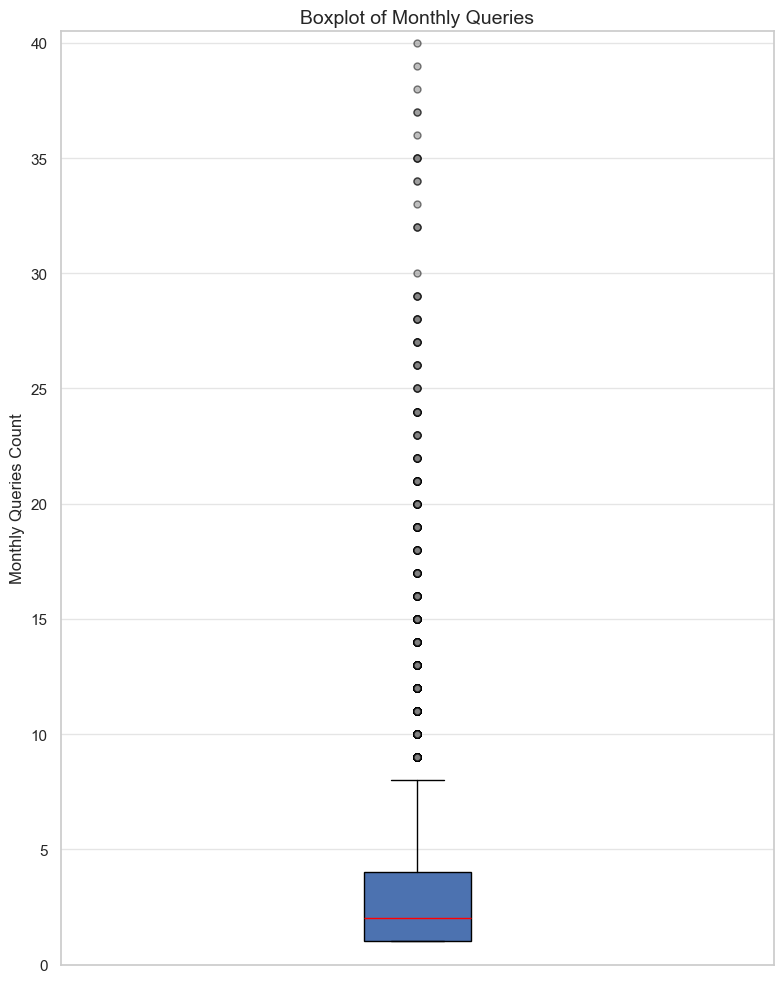

In [48]:
plt.figure(figsize=(8, 10))
plt.boxplot(
    user_engagement['monthly_queries'],
    vert=True,  
    patch_artist=True,  
    medianprops=dict(color='red'), 
    flierprops=dict(marker='o', markersize=5, markerfacecolor='grey', alpha=0.5) 
)
plt.title('Boxplot of Monthly Queries', fontsize=14)
plt.ylabel('Monthly Queries Count', fontsize=12)
plt.ylim(0, user_engagement['monthly_queries'].quantile(0.99) * 1.5)

plt.grid(axis='y', alpha=0.5)
plt.xticks([]) 
plt.tight_layout()
plt.show()


In [49]:
query_percentiles = user_engagement['monthly_queries'].quantile([0.5, 0.75, 0.9, 0.95, 0.99,1]).to_frame(name='Query_Count')
query_percentiles.index = [f'{int(p*100)}th Percentile' for p in query_percentiles.index]
query_percentiles

,Query_Count
50th Percentile,2.0
75th Percentile,4.0
90th Percentile,9.0
95th Percentile,13.0
99th Percentile,27.0
100th Percentile,127.0


- **Median** ( Red Line): Very low ~2
- **IQR** is pretty tight between 1 and 4
- Outliers above the main box ( Considering 99th percentile is 27): **Defining Power Users with >=30 query count per month**

In [50]:
event_percentiles = user_engagement['distinct_event_types'].quantile([0.5, 0.75, 0.9, 0.95, 0.99,1]).to_frame(name='Event_Count')
event_percentiles.index = [f'{int(p*100)}th Percentile' for p in event_percentiles.index]
event_percentiles

,Event_Count
50th Percentile,2.0
75th Percentile,2.0
90th Percentile,3.0
95th Percentile,3.0
99th Percentile,3.0
100th Percentile,3.0


### We can assume minimum event types should be 3 ( 90th or 95th percentile) to be considered to be a part of Power User

``In a nutshell a Power User: Greater than 30 queries and covering all event types i.e. 3``

In [51]:
#Engagement Level Based on Assumption Logic
def engagement_level(row):
    if row['monthly_queries'] >= 30 and row['distinct_event_types'] == 3:
        return 'Power User'
    # using 95ht percentile
    elif row['monthly_queries'] >= 13:
        return 'High Engagement'
    # using 75th percentile
    elif row['monthly_queries'] >= 4:
        return 'Medium Engagement'
    # using 50th percentile
    elif row['monthly_queries'] >= 2:
        return 'Low Engagement'
    else:
        return 'Inactive'

In [52]:
user_engagement['engagement_level'] = user_engagement.apply(engagement_level, axis=1)

`What potential issues or data quality concerns does the data surface?(These could be anomalies, missing data, inconsistent definitions, etc.)`

[]

<Figure size 1000x600 with 0 Axes>

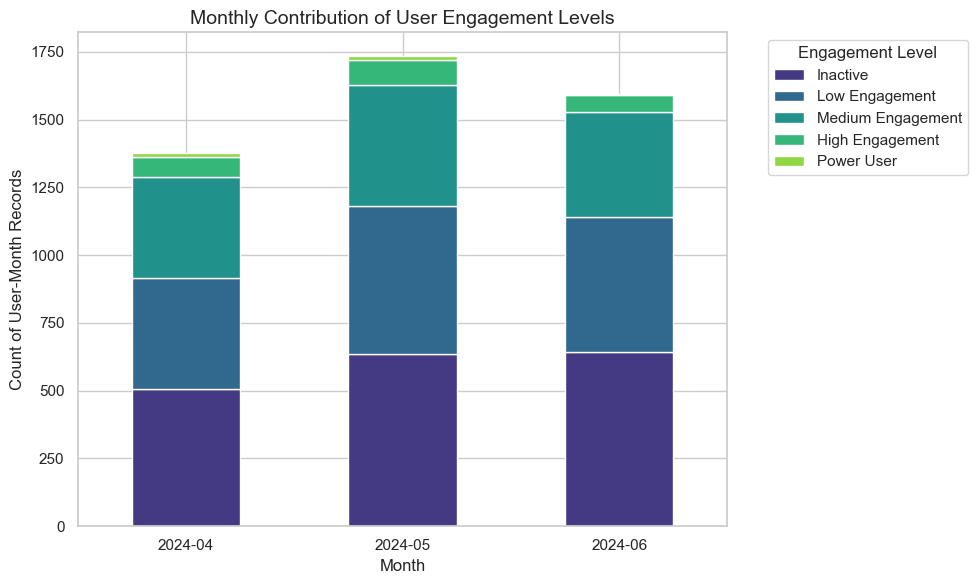

In [53]:
# use the order to stack in for nominal category
engagement_order = ['Inactive', 'Low Engagement', 'Medium Engagement', 'High Engagement', 'Power User']


monthly_contribution = user_engagement.groupby(['activity_month', 'engagement_level']).size().reset_index(name='record_count')
monthly_pivot = monthly_contribution.pivot(
    index='activity_month', 
    columns='engagement_level', 
    values='record_count'
).fillna(0)
monthly_pivot = monthly_pivot.reindex(columns=engagement_order, fill_value=0)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

ax = monthly_pivot.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6),
    color=sns.color_palette("viridis", len(engagement_order))
)

# Formatting
ax.set_title('Monthly Contribution of User Engagement Levels', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Count of User-Month Records', fontsize=12)

# Format x-axis labels to show Year-Month
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_pivot.index], rotation=0)
plt.legend(title='Engagement Level', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()

plt.plot()

In [54]:
# show overall statistics
engagement_breakdown = user_engagement['engagement_level'].value_counts(normalize=True).mul(100).round(2).reset_index()
engagement_breakdown.columns = ['Engagement Level', 'Percentage']

# Define the order for the engagement levels for better readability/reporting
level_order = ['Power User', 'High Engagement', 'Medium Engagement', 'Low Engagement', 'Inactive']
engagement_breakdown['Engagement Level'] = pd.Categorical(
    engagement_breakdown['Engagement Level'], categories=level_order, ordered=True
)
engagement_breakdown = engagement_breakdown.sort_values('Engagement Level')

# 4. Print the formatted result
print("--- Overall Percentage Distribution of User Engagement Levels ---")
print(engagement_breakdown.to_markdown(index=False, numalign="left", stralign="left"))

--- Overall Percentage Distribution of User Engagement Levels ---
| Engagement Level   | Percentage   |
|:-------------------|:-------------|
| Power User         | 0.76         |
| High Engagement    | 4.8          |
| Medium Engagement  | 25.72        |
| Low Engagement     | 30.79        |
| Inactive           | 37.93        |


`What potential issues or data quality concerns does the data surface?(These could be anomalies, missing data, inconsistent definitions, etc.)`

- **Non-null feedback_score** (18832 non-null entries out of 18832 entries): Feedback by customers is usually optional, the data looks unreal ( clarification required whether the score is provided by customer or is an internal quality tracking metric)
- **User to Firm Mapping** We had only 1 datapoint where  active users>provisioned users , still we need to have clear source for firm and user_id mapping to improve data reliability
- **Low + Inactive** Contributes to ~69% of overall contribution(1-3 queries) can see out of all provisioned users are on the shelf ( not actively using our platform) targeting these users for feature adpotion can reduce business health risk
